In [1]:
import os
from glob import glob

import torch
from torchvision import datasets, transforms
os.environ["KMP_DUPLICATE_LIB_OK"]="True"


In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("./data", train = True, download = True,
                  transform = transforms.Compose([
                      transforms.ToTensor()
                  ])),
    batch_size = 1
)

In [4]:
image, label = next(iter(train_loader))

In [5]:
image.shape, label.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

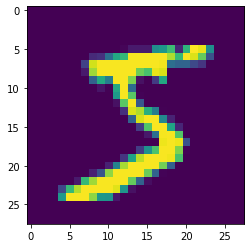

In [6]:
plt.imshow(image[0, 0, :, :])

## 각 Layer 별 설명 ##

In [27]:
import torch
# weight 포함
import torch.nn as nn
# activation 함수
import torch.nn.functional as F

## Convolution ##

- in_channels : 받게 될 channel의 갯수
- out_channels: 보내고 싶은 channel의 갯수
- kernel_size : 만들고 싶은 kernel(weights)의사이즈

In [8]:
nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

In [9]:
layer = nn.Conv2d(1, 20, 5, 1).to(torch.device("cpu"))
layer

Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))

- weight 시각화를 위해 slice하고 numpy화

In [14]:
weight = layer.weight
weight.shape

torch.Size([20, 1, 5, 5])

- 여기서 weight는 학습 가능한 상태이기 때문에 바로 numpy로 뽑아낼 수 없음
- detach() method는 그래프에서 잠깐 빼서 gradient에 영향을 받지 않게 함

In [15]:
# weight가 있을시 detach()를 해야 numpy화 할 수 있음
weight = weight.detach().numpy()

In [16]:
weight.shape

(20, 1, 5, 5)

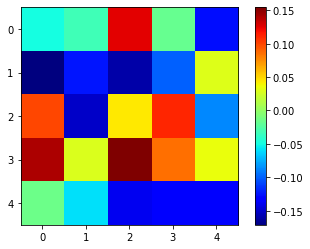

In [17]:
plt.imshow(weight[0, 0, :, :], "jet")
plt.colorbar()

- output 시각화 준비를 위해 numpy 화

In [18]:
output_data = layer(image)

In [20]:
output_data = output_data.data

In [21]:
output = output_data.cpu().numpy()

In [22]:
output.shape

(1, 20, 24, 24)

- input으로 들어간 이미지 numpy화

In [23]:
image_arr = image.numpy()
image_arr.shape

(1, 1, 28, 28)

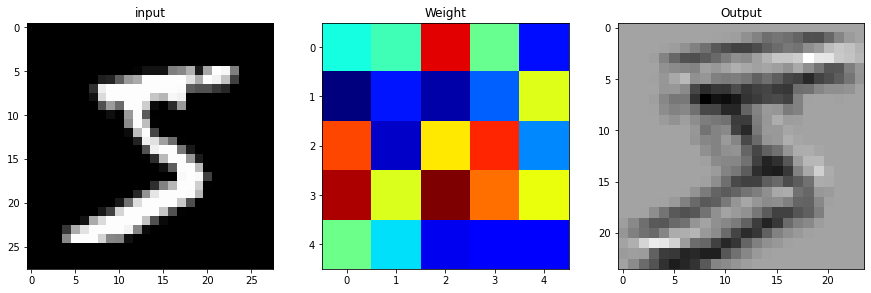

In [25]:
plt.figure(figsize = (15, 30))
plt.subplot(131)
plt.title("input")
plt.imshow(np.squeeze(image_arr), "gray")
plt.subplot(132)
plt.title("Weight")
plt.imshow(weight[0, 0, :, :], "jet")
plt.subplot(133)
plt.title("Output")
plt.imshow(output[0, 0, :, :], "gray")

## Pooling ##
input을 먼저 앞에 넣고ㅡ 뒤에 kernel 사이즈와 stride를 순서대로 넣음

In [28]:
image.shape

torch.Size([1, 1, 28, 28])

In [29]:
pool = F.max_pool2d(image, 2, 2)
pool.shape

torch.Size([1, 1, 14, 14])

- MaxPll Layer는 weight가 없기 때문에 바로 numpy()가 가능

In [30]:
pool_arr = pool.numpy()
pool_arr.shape

(1, 1, 14, 14)

In [31]:
image_arr.shape

(1, 1, 28, 28)

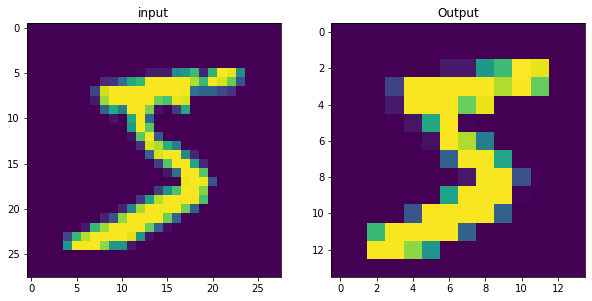

In [32]:
plt.figure(figsize = (10, 15))
plt.subplot(121)
plt.title("input")
plt.imshow(np.squeeze(image_arr))
plt.subplot(122)
plt.title("Output")
plt.imshow(np.squeeze(pool_arr))

## Linear ##
nn.Linear는 2d가 아닌 1d만 들어가기 때문에 .view() 1D로 펼쳐줘야함

In [34]:
flatten = image.reshape(1, 28 * 28)
flatten.shape

torch.Size([1, 784])

In [35]:
lin = nn.Linear(784, 10)(flatten)
lin.shape

torch.Size([1, 10])

In [36]:
lin

tensor([[-0.0918,  0.1490, -0.2246, -0.2155,  0.1364, -0.1968,  0.3545,  0.3590,
          0.2594, -0.4928]], grad_fn=<AddmmBackward>)

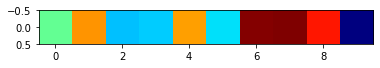

In [38]:
plt.imshow(lin.detach().numpy(), "jet")
plt.show()

## Softmax ##
결과를 numpy로 꺼내기 위해선 weight가 담긴 Linear에 Weight를 꺼줘야함

In [39]:
with torch.no_grad():
    flatten = image.reshape(1, 28 * 28)
    lin = nn.Linear(784, 10)(flatten)
    softmax = F.softmax(lin, dim = 1)

In [40]:
softmax

tensor([[0.1029, 0.0971, 0.0702, 0.1027, 0.1115, 0.1171, 0.1152, 0.1056, 0.0989,
         0.0790]])

In [41]:
np.sum(softmax.numpy())

0.99999994

## Layer 쌓기 ##

nn과 nn.functional의 차이점
- nn은 학습 파라미터가 담긴 것
- nn.functional은 학습 파라미터가 ㅇ벗는 것이라 생각하면 간단

In [52]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        # Feature Extraction
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        # print(x.shape)
        # Fully Connected(Classification)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [53]:
model = Net()

In [54]:
result = model.forward(image)

In [55]:
result

tensor([[-2.3162, -2.3659, -2.2831, -2.2671, -2.3332, -2.2621, -2.3486, -2.3195,
         -2.2767, -2.2601]], grad_fn=<LogSoftmaxBackward>)